In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature

import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [198]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

OBS3 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4_ERA5_minmaxmean_WA_5-20N.p', 'rb'))


In [71]:
OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_1000km2_CP25_ERA5_WA_5-20N.p', 'rb'))
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA5_5-20N.p', 'rb'))

In [72]:
OBS.keys()

dict_keys(['pgt01isvalid', 'shearmin', 'u_mid', 'p', 'lon', 'hour', 'tmean', 'area', 'lat', 'clat', 'tmin', 'q', 'pgt30', 'qmean', 'month', 't', 'umax_srfc', 'shearmean', 'clon', 'pmean', 'umin_mid', 'year', 'u_srfc', 'umean_mid', 'umean_srfc', 'pmax', 'shear', 'qmax'])

In [73]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    qup = np.array(dic['q650'])
    tup = np.array(dic['t650'])
    tlow = np.array(dic['t925'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    
    thetae_up = u_met.theta_e(650, tup-273.15, qup)
    thetae_down = u_met.theta_e(925, tlow-273.15, qq)
    
    thetae = thetae_down - thetae_up
    
    theta_up = u_met.theta(650, tup-273.15)
    theta_down = u_met.theta(925, tlow-273.15)
    
    theta = theta_down - theta_up

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        't650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'theta' : theta,
        'theta_e' : thetae,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [74]:
def create_dic_model(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) 
    tup = np.array(dic['t'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [199]:
obs_trmm = create_dic_model(OBS)
obs_gpm = create_dic(OBS2)
obs_40 = create_dic_model(OBS3)

In [200]:
np.max(obs_gpm.lat)

17.74562661158754

In [201]:
obs_trmm.q925

0        1.523821
1        1.480443
2        2.285421
3        1.924711
4        2.028690
5        1.949995
6        1.812212
7        1.787896
8       16.867974
9       16.528998
10      16.083856
11      16.060474
12       1.608431
13       1.654161
14       1.471905
15       1.333861
16       1.336792
17      17.500177
18      16.581255
19      16.741462
20      13.942682
21      15.667686
22      15.801657
23      16.763547
24      17.081992
25      17.142605
26      17.013140
27      17.051540
28      17.073009
29      16.276934
          ...    
8854    15.839659
8855    17.121969
8856    16.397725
8857    17.082205
8858    16.088171
8859    16.145855
8860    16.117672
8861    16.338170
8862    16.266382
8863    16.408072
8864    16.405041
8865     3.553318
8866    15.742651
8867    16.026136
8868     3.581255
8869     3.491874
8870     3.733597
8871     3.680537
8872    14.920611
8873    14.399989
8874    16.154718
8875     9.762715
8876    15.969699
8877    16.394226
8878    14

In [202]:
obs_trmm = obs_trmm[(obs_trmm.lon>=-10)&(obs_trmm.lon<=12)&(obs_trmm.lat>=5.2)&(obs_trmm.lat<=8.5)& (obs_trmm.month>=3) & (obs_trmm.month<=11)]  #5.2 - 8.3
obs_gpm = obs_gpm[(obs_gpm.lon>=-10)&(obs_gpm.lon<=12)&(obs_gpm.lat>=5.2)&(obs_gpm.lat<=8.5)& (obs_gpm.month>=3) & (obs_gpm.month<=11)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
obs_40 = obs_40[(obs_40.lon>=-10)&(obs_40.lon<=12)&(obs_40.lat>=5.2)&(obs_40.lat<=8.5)& (obs_40.month>=3) & (obs_40.month<=11)]


In [203]:
dss = [obs_trmm, obs_40]
for dataset in dss:
    mask = (np.isfinite(dataset['prcp']))
    for k in dataset.keys():
        dataset[k] = (dataset[k])[mask]

In [204]:
print('OBS_40', obs_40.lat.min(), obs_40.lat.max(), obs_40.lon.min(), obs_40.lon.max())
print('OBS_trmm', obs_trmm.lat.min(), obs_trmm.lat.max(), obs_trmm.lon.min(), obs_trmm.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

OBS_40 5.241751670837402 8.481751918792725 -9.980758666992188 11.747512817382812
OBS_trmm 5.201251745223999 8.481751918792725 -9.96051025390625 11.66650390625
OBS_gpm 5.200702670852864 8.499722291546048 -9.999745325933343 11.784652297234905


In [205]:
obs_trmm.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q925', 'shear', 'tmean', 'tmin',
       'u650', 'u925'],
      dtype='object')

Text(0.5, 1.0, 'nan')

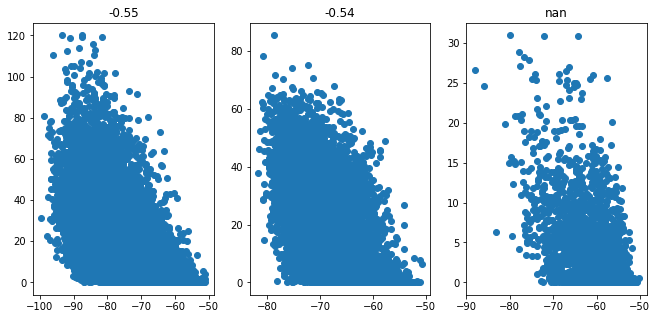

In [206]:
obss = [obs_trmm.tmin, obs_trmm.prcp] # p25
cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [obs_40.tmin, obs_40.prcp] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)


(8, 19)

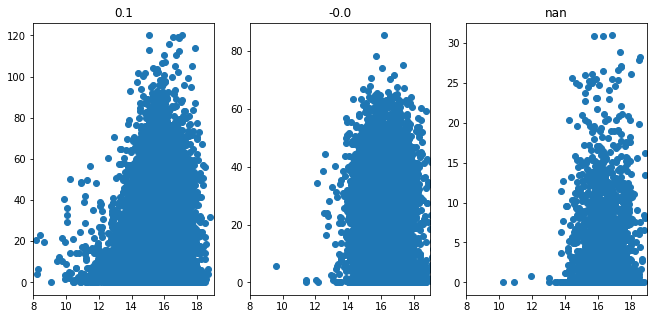

In [207]:
obss = [obs_trmm.q925, obs_trmm.prcp] # p25
cp4s = [obs_gpm.q925, obs_gpm.prcp] # gpm
cp25s = [obs_40.q925, obs_40.prcp] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))
ax.set_xlim(8,19)

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)
ax.set_xlim(8,19)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
ax.set_xlim(8,19)
#ax.set_ylim(13,19)


Text(0.5, 1.0, 'nan')

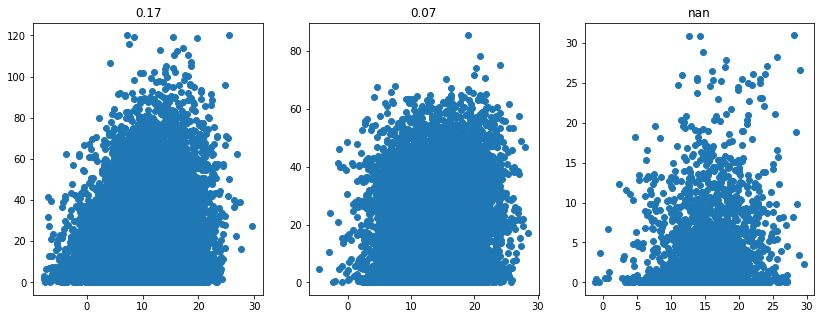

In [208]:
obss = [obs_trmm.shear, obs_trmm.prcp] # p25
cp4s = [obs_gpm.shear, obs_gpm.prcp] # gpm
cp25s = [obs_40.shear, obs_40.prcp] #cp4


f = plt.figure(figsize=(14,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

In [209]:
tl = []
for m in range(2,12):
    try:
        dat = obs_trmm[(obs_trmm.month==m)]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 75)
    except:
        continue
    print(m,out)
    tl.append(out)

3 9.357193425185375
4 7.864673173953691
5 8.998553519546723
6 9.34844764837861
7 10.83184820022057
8 11.475125409490207
9 12.00147762841684
10 10.241518676606796
11 9.395097527400504


In [210]:
pl = []
for m in range(2,12):
    try:
        dat = obs_gpm[obs_gpm.month==m]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 98)
    except:
        continue
    print(m,out)
    pl.append(out)

3 65.52768412080802
4 70.85700363560487
5 76.55811308860832
6 75.32290689356344
7 63.01935774126444
8 53.871120278790826
9 62.95320372658493
10 61.12030549761096
11 58.38360016020936


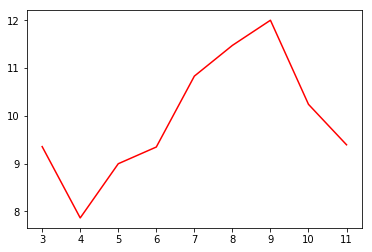

In [211]:
#plt.plot(np.arange(3,12), pl)
plt.plot(np.arange(3,12), tl, 'r')

In [212]:
print(obs_trmm.area.min())
print(obs_gpm.area.min())
print(obs_40.area.min())

58.08000000000001
5000
58.08000000000001


In [213]:
ptrmm = []
pgpm = []
ptrmm40 = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[(obs_trmm.month == m) & (obs_trmm.prcp>1)],95))
    pgpm.append(np.percentile(obs_gpm.prcp[(obs_gpm.month == m) & (obs_gpm.prcp>1)],95))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[(obs_40.month == m) & (obs_40.prcp>1),95]))
    except:
        ptrmm40.append(np.nan)

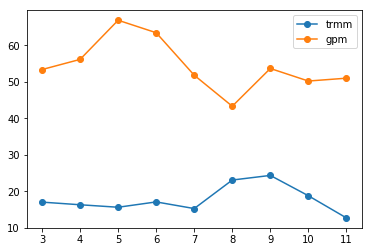

In [214]:
plt.figure()
plt.plot(range(3,12), ptrmm, '-o', label='trmm')
plt.plot(range(3,12), pgpm, '-o',label='gpm')
#plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

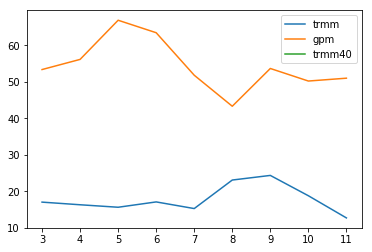

In [215]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')

plt.legend()

In [216]:
ptrmm = []
pgpm = []
ptrmm40 = []
gridsat = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[obs_trmm.month == m],99))
    pgpm.append(np.percentile(obs_gpm.prcp[obs_gpm.month == m],99))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[obs_40.month == m],99))
    except:
        ptrmm40.append(np.nan)

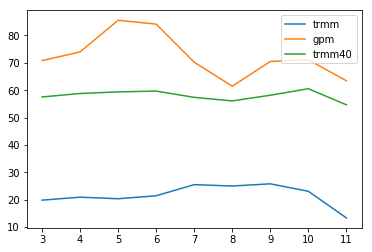

In [217]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

3 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
4 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
5 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
6 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
7 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
8 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
9 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
10 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
11 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
3 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
4 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/

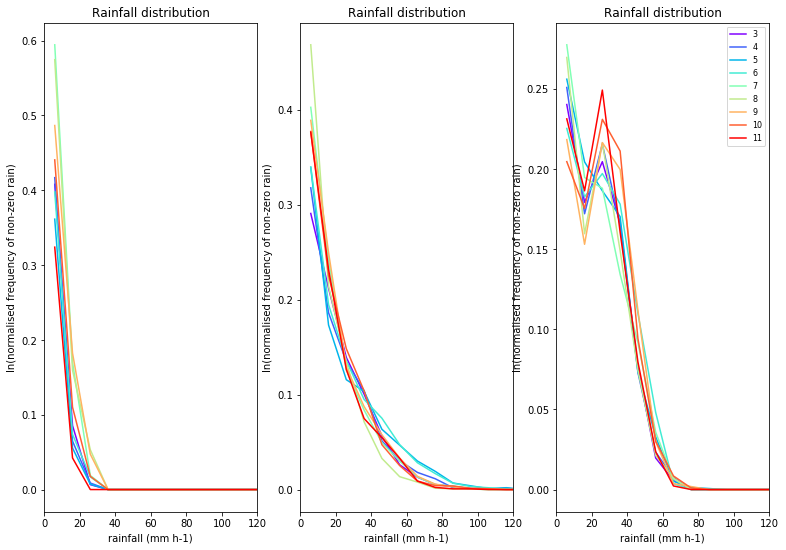

In [218]:
f = plt.figure(figsize=(13,9))

for ids, data in enumerate([obs_trmm, obs_gpm, obs_40]):
    #ipdb.set_trace()
    ax = f.add_subplot(1,3,ids+1)
    colors = cm.rainbow(np.linspace(0,1,9))
    for m,c in zip(np.arange(3,12),colors):
        #print(m)
        
        monthly = (data['prcp'])[data['month'] == m]

        print(m, np)

        #ipdb.set_trace()
        weights = np.ones_like(monthly) / float(len(monthly))
        hist, h = np.histogram(monthly, bins=np.arange(1,201+1,10),  range=(1,201), weights=weights)
        #print(np.arange(20,120+1,10))
        bins=np.arange(1,201+1,10)
        #line, = ax.semilogy(hist, color=c, lw=2, label=str(m))
        mid = bins[1::]-5
        ax.plot(mid,hist, color=c, label=str(m))
    plt.ylabel('ln(normalised frequency of non-zero rain)')
    plt.xlim((0,120))
    plt.xlabel('rainfall (mm h-1)')
    
    plt.title('Rainfall distribution')

plt.legend(fontsize=8)


In [219]:
oposi = (obs_gpm.q925>=10) & (obs_gpm.u650<0) &  (obs_gpm.prcp>=8)# & ((obs_gpm.month>=9) | (obs_gpm.month<=5))
cposi = (obs_40.q925>=10) & (obs_40.u650<0) &  (obs_40.prcp>=5) & (np.isfinite(obs_40.q925)) & (np.isfinite(obs_40.shear))
pposi = (obs_trmm.q925>=10) &(obs_trmm.u650<0) &  (obs_trmm.prcp>=1) & (np.isfinite(obs_trmm.q925)) & (np.isfinite(obs_trmm.shear))

In [220]:
obsp = obs_gpm[oposi]
cp4 = obs_40[cposi]
p25 = obs_trmm[pposi]

In [221]:
obsp.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q650', 'q925', 'shear', 't650',
       't925', 'theta', 'theta_e', 'tmean', 'tmin', 'u650', 'u925'],
      dtype='object')

In [222]:
len(obsp)

11655

In [223]:
len(p25)

1251

In [224]:
len(cp4)

6957

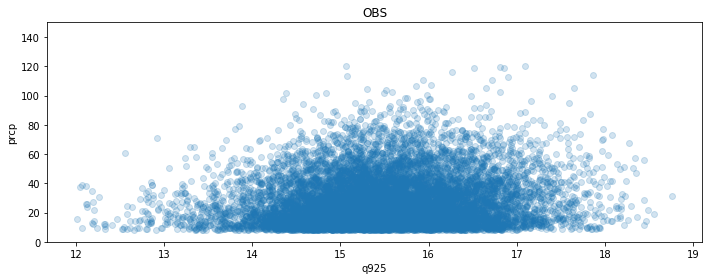

In [225]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).q925, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

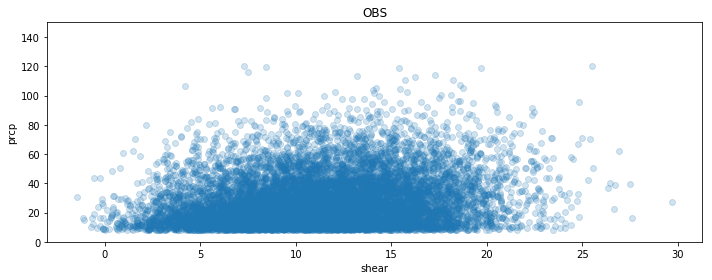

In [226]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).shear, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('shear')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

In [227]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    rr = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

In [228]:
print(obsp['q925'].median())
print(obsp['shear'].median())
print(obsp['prcp'].median())
print(obsp['tmin'].median())
print(obsp['theta_e'].median())

15.470990911126137
11.249792098999023
22.808320524139248
-79.33127473587697
10.335084970439596


In [229]:
print(obsp['q925'].mean())
print(obsp['shear'].mean())
print(obsp['prcp'].mean())
print(obsp['tmin'].mean())
print(obsp['theta_e'].mean())

15.484467444998137
11.293865621294499
27.57434352574514
-78.9801065969251
10.649006920412893


In [230]:
nbqq = 9
nbss = 9

p1 = 1
p2 = 99
qbinso = np.linspace(np.percentile(obsp.q925,p1) , np.percentile(obsp.q925, p2), nbqq)
shear_obsp = np.linspace(np.percentile(obsp.shear, p1) , np.percentile(obsp.shear, p2), nbss)

q4 = np.linspace(np.percentile(cp4.q925,p1) , np.percentile(cp4.q925, p2), nbqq)
shear4 = np.linspace(np.percentile(cp4.shear, p1) , np.percentile(cp4.shear, p2), nbss)

q25 = np.linspace(np.percentile(p25.q925,p1) , np.percentile(p25.q925, p2), nbqq)
shear25 = np.linspace(np.percentile(p25.shear, p1) , np.percentile(p25.shear, p2), nbss)



In [231]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.nanmean(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.nanmean(ds.prcp[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
            except:
                prcp_mean = np.nan

            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outval

In [232]:
def hist2d_plot(data,xbins, ybins, vmin, vmax, valid=None):
    f = plt.figure()
    ax5 = f.add_subplot(111)
    X, Y = np.meshgrid(xbins,ybins)
    cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
    if valid is not None:
        data[valid<10] = np.nan
    Zm = ma.masked_where(np.isnan(data),data)

    mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=vmin, vmax=vmax) # viridis_rvmin=20, vmax=40
    #mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp) # viridis_rvmin=20, vmax=40

    ax5.set_ylabel('Max. q925hPa')
    ax5.set_xlabel('Max. u925hPa (equally populated)')
    ax5.set_title('')
    cbar = f.colorbar(mappable, ticks=np.linspace(vmin,vmax,9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label('90th centile max. rain')
    plt.show()

In [233]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 

In [234]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,3,i+1)
        if i>2:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
   # plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_pcp.png')

In [235]:
def hist2d_two(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(12,5))
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)

    plt.tight_layout() 
  #  plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_obsOnly.png')

In [236]:
cpobsperc, pcobs,  obsval = create_2dhist(obsp, shear_obsp, qbinso)

In [237]:
tt4, pc4,  val4 = create_2dhist(cp4, shear4, q4)

In [238]:
cp4.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q925', 'shear', 'tmean', 'tmin',
       'u650', 'u925'],
      dtype='object')

In [239]:
np.sum(np.isnan(cp4.shear))

0

In [240]:
tt25, pc25, val25 = create_2dhist(p25, shear25, q25)

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


In [241]:


tmin_dic_obs = {
    'data' : cpobsperc,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Average minimum temperature',
    'valid' : obsval,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],1),
    'vmax' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

pcobs[pcobs==0]=np.nan
prcp_dic_obs = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Average maximum precipitation',
    'valid' : obsval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],1),
    'vmax' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}



In [242]:
data = tt4

tmin_dic_cp4 = {
    
    'data' : data,
    'ybins' : q4,
    'xbins' : shear4,
    'title' : 'Average minimum temperature',
    'valid' : val4,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(data[(data!=0) & np.isfinite(data)],1),
    'vmax' : np.percentile(data[(data!=0) & np.isfinite(data)],98),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

pc4[pc4==0]=np.nan
data = pc4
prcp_dic_cp4 = {
    'data' : data,
    'ybins' : q4,
    'xbins' : shear4,
    'title' : 'Average maximum precipitation',
    'valid' : val4,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(data[(data!=0) & np.isfinite(data)],1),
    'vmax' : np.percentile(data[(pcobs!=0) & np.isfinite(data)],97),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


In [243]:
data = tt25

tmin_dic_p25 = {
    
    'data' : data,
    'ybins' : q25,
    'xbins' : shear25,
    'title' : 'Average minimum temperature',
    'valid' : val25,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(data[(data!=0) & np.isfinite(data)],1),
    'vmax' : np.percentile(data[(data!=0) & np.isfinite(data)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

pc25[pc25==0]=np.nan
data = pc25
prcp_dic_p25 = {
    'data' : data,
    'ybins' : q25,
    'xbins' : shear25,
    'title' : 'Average maximum precipitation',
    'valid' : val25,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(data[(data!=0) & np.isfinite(data)],1),
    'vmax' : np.percentile(data[(pcobs!=0) & np.isfinite(data)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


In [244]:
shearscat = np.repeat(shear_obsp,pcobs.shape[0],axis=0).reshape(pcobs.shape)

In [245]:
deltaPS = []
deltaQPS = []
sboxplot = []
tminbox = []
for sh in np.unique(shearscat):
        
        vals = pcobs[sh==shearscat]
        tvals = cpobsperc[sh==shearscat]
        deltaPS.append(np.nanmax(vals)-np.nanmin(vals))
        try:
            deltaQPS.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
        except:
            deltaQPS.append(np.nan)
        sboxplot.append(vals)
        tminbox.append(tvals)
print(np.median(np.array(deltaQPS)[np.isfinite(np.array(deltaQPS))]))

2.8180461763847706


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':


9
9


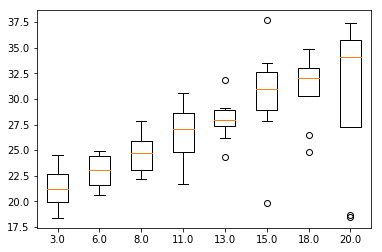

In [246]:
scoll = []
scollbins = np.round(np.unique(shearscat),2)
scollbins = np.round(scollbins[0:-1]+((scollbins[1::]-scollbins[0:-1])/2),0)
for b in sboxplot:
    scoll.append(b[np.isfinite(b)])
print(len(scoll))
print(len(np.unique(shearscat)))
ax = plt.boxplot(scoll[0:-1], labels=scollbins, whis=1)
box1= (scoll[0:-1],scollbins)

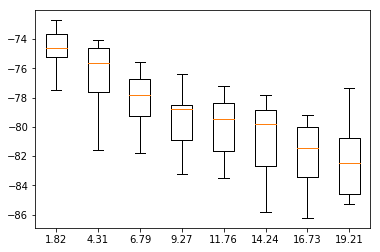

In [247]:
coll = []
for b in tminbox:
    coll.append(b[b!=0])
ax = plt.boxplot(coll[0:-1], labels=np.round(np.unique(shearscat),2)[0:-1])

0.5949520026852907
0.669109194651612


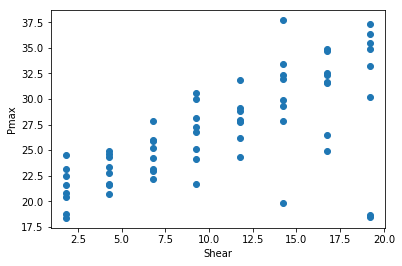

In [248]:
plt.scatter(shearscat, pcobs)
plt.xlabel('Shear')
plt.ylabel('Pmax')
shearfin = shearscat[np.isfinite(pcobs)]
pfin = pcobs[np.isfinite(pcobs)]
slope, intercept, r_value, p_value, std_err = stats.linregress(shearfin, pfin)
print(slope)
print(r_value)

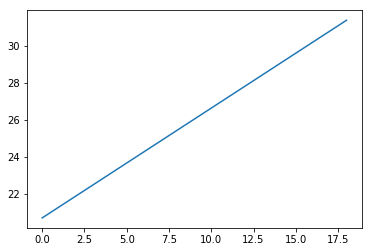

In [249]:
plt.plot(intercept+slope*range(19))

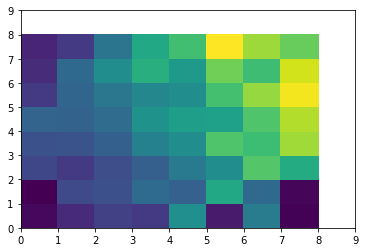

In [250]:
plt.pcolormesh(pcobs.T)

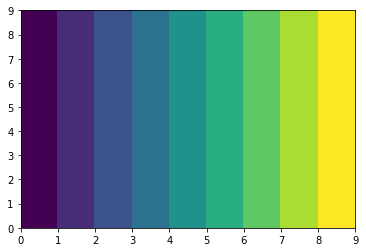

In [251]:
plt.pcolormesh(shearscat.T)

1.849059646589615
0.4901775095523991


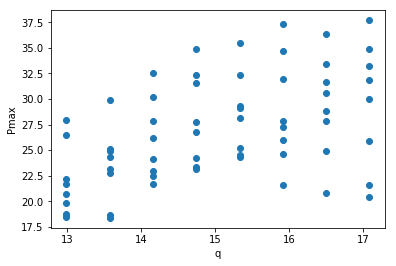

In [252]:
qscat = np.repeat(qbinso[np.newaxis,:],pcobs.shape[0],axis=0).reshape(pcobs.shape)
plt.scatter(qscat, pcobs)
plt.xlabel('q')
plt.ylabel('Pmax')
qfin = qscat[np.isfinite(pcobs)]
pfin = pcobs[np.isfinite(pcobs)]
qslope, qintercept, qr_value, qp_value, qstd_err = stats.linregress(qfin, pfin)
print(qslope)
print(qr_value)

In [253]:
deltaPQ = []
deltaQPQ = []
boxplotq = []
tminboxq = []
for qr in np.unique(qscat):
        
        vals = pcobs[qr==qscat]
        tvals = cpobsperc[qr==qscat]
        deltaPQ.append(np.nanmax(vals)-np.nanmin(vals))
        try:
            deltaQPQ.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
        except:
            deltaQPQ.append(np.nan)
        boxplotq.append(vals)
        tminboxq.append(tvals)
print(np.median(np.array(deltaQPQ)[np.isfinite(np.array(deltaQPQ))]))

5.300513819810938


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':


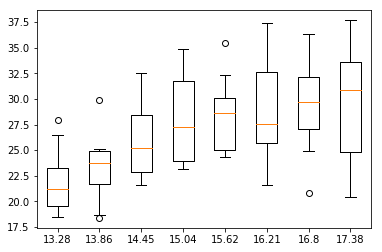

In [254]:
coll = []
qcollbins = np.round(np.unique(qscat),2)
qcollbins = np.round(qcollbins[0:-1]+((qcollbins[1::]-qcollbins[0:-1])/2),2)
for b in boxplotq:
    coll.append(b[np.isfinite(b)])
ax = plt.boxplot(coll[0:-1], labels=qcollbins, whis=1)
box2= (coll[0:-1],qcollbins)

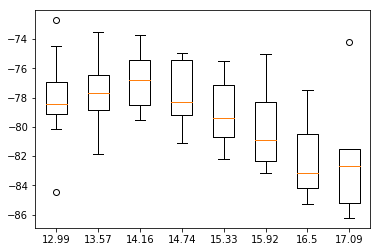

In [255]:
coll = []
for b in tminboxq:
    coll.append(b[b!=0])
ax = plt.boxplot(coll[0:-1], labels=np.round(np.unique(qscat),2)[0:-1])

In [256]:
print(qslope)
print(slope)

1.849059646589615
0.5949520026852907


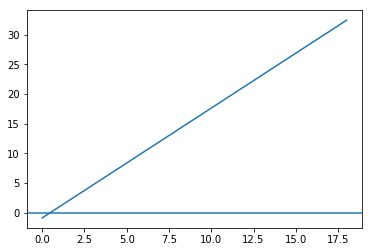

In [257]:
plt.plot(qintercept+qslope*range(19))
plt.axhline(0)

In [258]:
sensitivity = {}
sensitivity['shear_slope'] = slope
sensitivity['qslope'] = qslope 
pkl.dump(sensitivity, open(cnst.CLOVER_SAVES + 'q_shear_sensitivity_slopes', 'wb'))

In [259]:
data_list = [tmin_dic_obs, tmin_dic_cp4, tmin_dic_p25,prcp_dic_obs, prcp_dic_cp4, prcp_dic_p25]

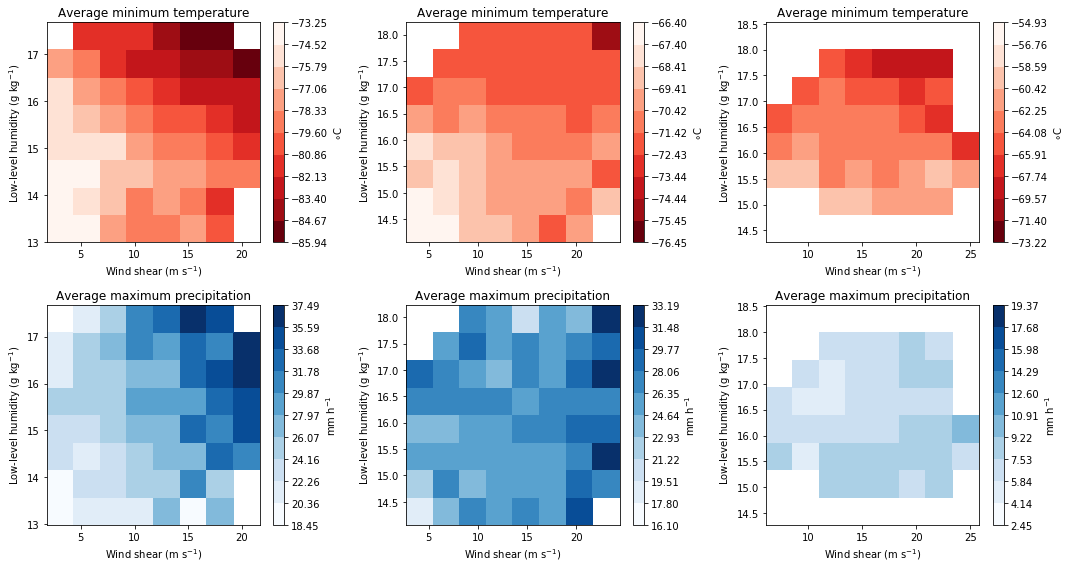

In [260]:
hist2d_six(data_list, valid=True)